# Processing data

In [1]:
import pandas as pd

In [2]:
wiki_data = pd.read_csv('data/wikipedia/subsetted_wiki_data_full_text_text_chunks.csv')

In [3]:
%matplotlib inline


In [4]:
wiki_data['article_size'] = wiki_data.text.apply(lambda x: len(x))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9babf7aa90>]],
      dtype=object)

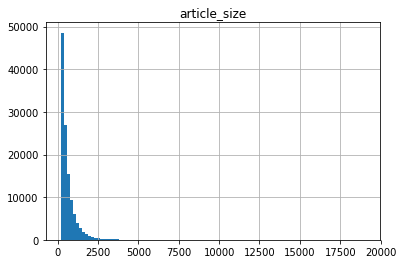

In [5]:
wiki_data.hist(column='article_size', bins=100)

In [6]:
import os
import random
import codecs
from collections import defaultdict

from gensim.models.ldamodel import LdaModel as Lda
from gensim import corpora
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from nltk import pos_tag

import enchant
spelling_dict = enchant.Dict("en_US")

stop = set(stopwords.words('english'))
lemma = WordNetLemmatizer()
stemmer = PorterStemmer()

stemmed_dict = defaultdict(set)

def stem_and_update_stem_dict(tokens):
    output_list = []
    for token in tokens:
        stemmed = stemmer.stem(token)
        if stemmed != token:
            stemmed_dict[stemmed].add(token)
        output_list.append(stemmed)
    return output_list
        
list_of_POS_to_ignore = ['WRB', 'WP$', 'WP',  'WDT', 'UH', 
                         'TO', 'RP', 'RBS', 'RBR', 'PRP$', 'PRP', 
                        'MD', 'JJS', 'JJR', 'JJ', 'IN', 'FW', 'EX', 
                         'DT', 'CD']

# Function to remove stop words from sentences & lemmatize verbs. 
def clean(doc):
    tokens = word_tokenize(doc)
    #removing stop words 
    tokens = [i for i in tokens if i not in stop]
    # removing pos data 
    tokens = [word for word, pos in pos_tag(tokens) if pos not in list_of_POS_to_ignore]
    # Removing improperly spelled words (pronouns must be capitalized to be spelled right)
    tokens = [word for word in tokens if spelling_dict.check(word)]
    # lowercase
    tokens = [word.lower() for word in tokens]
    # lemmatized
    tokens = [lemma.lemmatize(word, 'v') for word in tokens]
    # removing short words 
    tokens = [s for s in tokens if len(s) > 2]
    # stemmed
#     tokens = stem_and_update_stem_dict(tokens)
    
    return tokens

In [7]:
tokenized_text = wiki_data.text.apply(lambda x: clean(str(x)))

In [8]:
from gensim import corpora

dictionary = corpora.Dictionary(tokenized_text)

In [9]:
original_words = set(dictionary.token2id.keys())

In [10]:
len(original_words)

42429

In [11]:
dictionary.filter_extremes(no_below=10, no_above=0.4)

In [12]:
reduced_number = set(dictionary.token2id.keys())
len(reduced_number)

20083

In [13]:
# Remove the 50 most common words that showed up
dictionary.filter_n_most_frequent(50)

In [14]:
reduced_number - set(dictionary.token2id.keys())

{'age',
 'also',
 'american',
 'bear',
 'become',
 'begin',
 'build',
 'call',
 'change',
 'city',
 'come',
 'die',
 'find',
 'first',
 'form',
 'get',
 'give',
 'group',
 'include',
 'know',
 'later',
 'live',
 'make',
 'mean',
 'name',
 'new',
 'number',
 'often',
 'part',
 'people',
 'place',
 'play',
 'release',
 'say',
 'show',
 'south',
 'start',
 'state',
 'take',
 'time',
 'unite',
 'university',
 'use',
 'war',
 'well',
 'work',
 'world',
 'write',
 'year',
 'years'}

In [15]:
# Define the corpus with the narrowed dictionary
corpus = [dictionary.doc2bow(text) for text in tokenized_text]

In [16]:
import os
import gensim

In [19]:
# Set up log to terminal
import logging
logging.basicConfig(filename='lda_model.log', 
                    format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


In [17]:
import gensim

for number_of_topics in [50, 100, 200, 250, 300]:
    NUM_TOPICS = number_of_topics
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics = NUM_TOPICS, 
                                               chunksize=5000, iterations=100, passes=1)
    
    title = '180925_wikipedia_model.individually_binned.' + str(number_of_topics) + '.gensim.'

    ldamodel.save(os.path.join('models', title))

    topics = ldamodel.print_topics(num_words=4, num_topics=number_of_topics)

    for topic in topics:
        print(topic)

(0, '0.107*"football" + 0.070*"league" + 0.061*"team" + 0.055*"division"')
(1, '0.066*"color" + 0.028*"wisconsin" + 0.015*"black" + 0.013*"sun"')
(2, '0.036*"london" + 0.027*"bird" + 0.021*"egg" + 0.017*"breed"')
(3, '0.092*"district" + 0.062*"india" + 0.034*"pakistan" + 0.009*"tamil"')
(4, '0.132*"saint" + 0.017*"colony" + 0.016*"ship" + 0.014*"kennedy"')
(5, '0.035*"letter" + 0.022*"beach" + 0.017*"prize" + 0.015*"chamber"')
(6, '0.022*"radio" + 0.021*"value" + 0.017*"ball" + 0.011*"hand"')
(7, '0.047*"president" + 0.046*"party" + 0.028*"minister" + 0.027*"government"')
(8, '0.050*"school" + 0.025*"till" + 0.020*"jersey" + 0.020*"college"')
(9, '0.053*"lake" + 0.044*"virginia" + 0.036*"iowa" + 0.034*"victoria"')
(10, '0.084*"island" + 0.038*"islands" + 0.027*"god" + 0.011*"gods"')
(11, '0.078*"province" + 0.053*"san" + 0.038*"texas" + 0.020*"italy"')
(12, '0.026*"energy" + 0.022*"cell" + 0.018*"earth" + 0.017*"press"')
(13, '0.058*"park" + 0.040*"system" + 0.035*"computer" + 0.027*"i

/home/wmvoje/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


(0, '0.069*"north" + 0.068*"storm" + 0.049*"florida" + 0.048*"hurricane"')
(1, '0.078*"paint" + 0.047*"italy" + 0.031*"picture" + 0.031*"art"')
(2, '0.114*"women" + 0.063*"airport" + 0.059*"men" + 0.058*"international"')
(3, '0.068*"species" + 0.048*"plant" + 0.031*"animals" + 0.030*"bird"')
(4, '0.040*"cell" + 0.029*"cells" + 0.021*"stage" + 0.020*"ball"')
(5, '0.106*"canada" + 0.047*"baseball" + 0.044*"columbia" + 0.030*"major"')
(6, '0.101*"english" + 0.052*"letter" + 0.046*"scotland" + 0.042*"sweden"')
(7, '0.220*"game" + 0.054*"canton" + 0.043*"player" + 0.041*"municipality"')
(8, '0.151*"award" + 0.072*"best" + 0.054*"prize" + 0.052*"academy"')
(9, '0.082*"earth" + 0.049*"ship" + 0.048*"sun" + 0.038*"moon"')
(10, '0.103*"air" + 0.071*"texas" + 0.058*"train" + 0.029*"flight"')
(11, '0.178*"movie" + 0.046*"film" + 0.030*"direct" + 0.029*"star"')
(12, '0.039*"article" + 0.031*"plane" + 0.029*"disorder" + 0.028*"label"')
(13, '0.060*"austria" + 0.052*"little" + 0.038*"creek" + 0.028*

(0, '0.192*"body" + 0.071*"shape" + 0.047*"feet" + 0.046*"ray"')
(1, '0.075*"represent" + 0.049*"carbon" + 0.047*"bond" + 0.046*"structure"')
(2, '0.120*"relationship" + 0.049*"gay" + 0.047*"retirement" + 0.043*"nova"')
(3, '0.312*"england" + 0.106*"royal" + 0.077*"palace" + 0.045*"walter"')
(4, '0.213*"football" + 0.164*"team" + 0.144*"league" + 0.052*"association"')
(5, '0.102*"train" + 0.078*"islands" + 0.066*"central" + 0.057*"minutes"')
(6, '0.099*"slave" + 0.093*"trade" + 0.091*"free" + 0.056*"napoleon"')
(7, '0.257*"family" + 0.075*"species" + 0.045*"genus" + 0.037*"job"')
(8, '0.193*"children" + 0.097*"letter" + 0.068*"someone" + 0.065*"something"')
(9, '0.080*"kong" + 0.065*"hong" + 0.047*"combination" + 0.047*"surgery"')
(10, '0.151*"development" + 0.093*"crash" + 0.065*"partner" + 0.058*"turkey"')
(11, '0.207*"island" + 0.043*"islands" + 0.038*"ago" + 0.032*"fossil"')
(12, '0.115*"little" + 0.104*"young" + 0.080*"interview" + 0.070*"creek"')
(13, '0.096*"channel" + 0.055*"sp

(0, '0.158*"wisconsin" + 0.085*"lincoln" + 0.064*"address" + 0.063*"edit"')
(1, '0.154*"official" + 0.078*"fifth" + 0.072*"italian" + 0.067*"painter"')
(2, '0.270*"president" + 0.061*"chief" + 0.040*"iraq" + 0.039*"bush"')
(3, '0.131*"visit" + 0.112*"bomb" + 0.074*"prisoners" + 0.066*"japanese"')
(4, '0.131*"selena" + 0.103*"nfl" + 0.086*"warner" + 0.051*"bros"')
(5, '0.080*"protect" + 0.077*"gun" + 0.076*"security" + 0.047*"select"')
(6, '0.065*"munich" + 0.063*"duty" + 0.058*"tomb" + 0.054*"giovanni"')
(7, '0.123*"shape" + 0.062*"shell" + 0.050*"madrid" + 0.044*"tribe"')
(8, '0.132*"data" + 0.128*"access" + 0.081*"belgium" + 0.043*"memory"')
(9, '0.238*"germany" + 0.181*"design" + 0.049*"german" + 0.037*"set"')
(10, '0.342*"school" + 0.190*"family" + 0.068*"students" + 0.046*"graduate"')
(11, '0.127*"shark" + 0.078*"chase" + 0.074*"borough" + 0.049*"fin"')
(12, '0.135*"harris" + 0.109*"future" + 0.077*"every" + 0.069*"beatles"')
(13, '0.064*"apple" + 0.060*"document" + 0.051*"phone" 

In [ ]:
ldamodel.print_topics(num_words=4, num_topics=100)

# Loading in a model

In [21]:
subsetted_data = pd.read_csv('data/wikipedia/subsetted_wiki_data_full_text_text_chunks_leftout.csv')

In [22]:
tokenized_text_leftout = subsetted_data.text.apply(lambda x: clean(str(x)))

In [24]:
ldamodel.id2word

In [25]:
corpus_leftout = [ldamodel.id2word.doc2bow(text) for text in tokenized_text_leftout]

In [51]:
lda_vector = []

for number_of_topics in [10, 25, 50, 100, 200, 500, 1000]:
    
   
    
    title = '180924_wikipedia_model.stemmed.individually_binned.' + str(number_of_topics) + '.gensim.'

    sample_model = Lda.load('models/' + title)
    
    print(str(number_of_topics))
    output = sample_model.log_perplexity(corpus_leftout)
    output2 = sample_model.bound(corpus_leftout)
    print(output)
    lda_vector.append((number_of_topics, output, output2))

10
-8.0762449388841
25
-8.073944573929047
50
-8.11676735336505
100
-10.632973436826251
200
-13.2835661761083
500
-20.715616568319597
1000
-32.834156295550734


In [52]:
test = pd.DataFrame(data=lda_vector, columns = ['Categories', 'log_perlexity', 'bounds'])

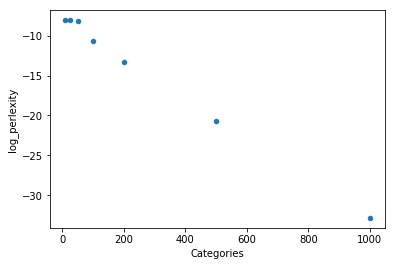

In [53]:
test.plot(x='Categories', y='log_perlexity', kind='scatter')

In [54]:
test['2_log_perplexity'] = 2**test.log_perlexity

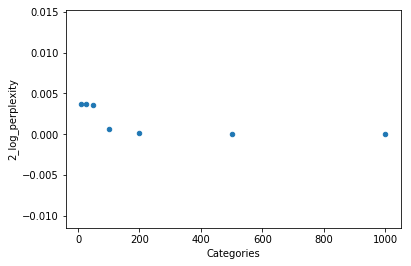

In [55]:
test.plot(x='Categories', y='2_log_perplexity', kind='scatter')

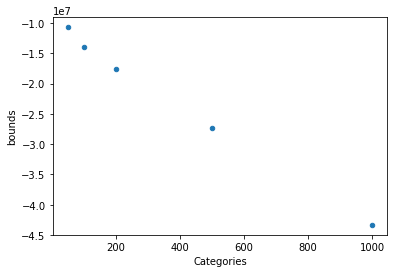

In [41]:
test.plot(x='Categories', y='bounds', kind='scatter')

In [31]:
lda_vector.append((1, 3))

In [30]:
sample_model = Lda.load('models/180922_wikipedia_model.stemmed.200.gensim.')

topics = sample_model.print_topics(num_words=6, num_topics=50)

for topic in topics:
    print(topic)

(68, '0.154*"centuri" + 0.076*"roman" + 0.061*"ancient" + 0.058*"greek" + 0.049*"period" + 0.046*"empir"')
(117, '0.201*"court" + 0.098*"case" + 0.067*"judg" + 0.067*"justic" + 0.055*"suprem" + 0.043*"count"')
(40, '0.174*"victoria" + 0.083*"conserv" + 0.058*"melbourn" + 0.052*"weather" + 0.048*"snake" + 0.042*"sail"')
(120, '0.273*"cite" + 0.256*"web" + 0.070*"marin" + 0.068*"journal" + 0.037*"citat" + 0.035*"iraq"')
(22, '0.447*"set" + 0.153*"rank" + 0.075*"captain" + 0.061*"save" + 0.049*"rifl" + 0.045*"column"')
(6, '0.150*"scienc" + 0.129*"oklahoma" + 0.128*"present" + 0.124*"fiction" + 0.107*"indian" + 0.054*"intellig"')
(172, '0.166*"right" + 0.078*"protect" + 0.062*"human" + 0.043*"convent" + 0.034*"activist" + 0.031*"ident"')
(186, '0.285*"game" + 0.102*"player" + 0.068*"video" + 0.037*"releas" + 0.029*"window" + 0.028*"brand"')
(103, '0.211*"art" + 0.117*"museum" + 0.109*"paint" + 0.076*"artist" + 0.055*"iron" + 0.051*"truck"')
(39, '0.201*"kingdom" + 0.133*"georg" + 0.119*"n